In [1]:
from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

np.set_printoptions(suppress=True)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

from IPython.display import display, Markdown

from sklearn.linear_model import LogisticRegression

In [2]:
path1 = Path(r"A:\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")
path2 = Path(r"C:\Users\rober\Documents\Workspace\Python\Masterarbeit\Kaggle Home Credit Datensatz")

if path1.is_dir():
    DATASET_DIR = path1
else:
    DATASET_DIR = path2

In [3]:
app_train = pd.read_csv(DATASET_DIR / "application_train.csv")
pa = pd.read_csv(DATASET_DIR / "previous_application.csv")
des = pd.read_csv(DATASET_DIR / "HomeCredit_columns_description.csv", encoding="latin", index_col=0)

In [4]:
pa = pd.merge(pa, app_train[["SK_ID_CURR","TARGET"]] ,on="SK_ID_CURR")

In [5]:
m_heads = [element for element in pa.columns if pa[element].dtype.name != "object"]

In [6]:
skip = ["SK_ID_PREV", "SK_ID_CURR", "TARGET"]

In [7]:
df = pa[m_heads]
df.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,TARGET
0,2030495,271877,1730.430,17145.0,17145.0,0.0,17145.0,15,1,0.000000,0.182832,0.867336,-73,35,12.0,365243.0,-42.0,300.0,-42.0,-37.0,0.0,0
1,1696966,271877,68258.655,1800000.0,1754721.0,180000.0,1800000.0,18,1,0.101325,NaN,NaN,-472,55,36.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2154916,271877,12417.390,108400.5,119848.5,0.0,108400.5,14,1,0.000000,NaN,NaN,-548,196,12.0,365243.0,-512.0,-182.0,-392.0,-387.0,0.0,0
3,2802425,108129,25188.615,607500.0,679671.0,NaN,607500.0,11,1,NaN,NaN,NaN,-164,-1,36.0,365243.0,-134.0,916.0,365243.0,365243.0,1.0,0
4,1536272,108129,21709.125,450000.0,512370.0,NaN,450000.0,9,1,NaN,NaN,NaN,-515,6,36.0,365243.0,-485.0,565.0,-155.0,-147.0,1.0,0


In [8]:
result = {
          "header":[],
          "rate":[],
          "des":[]
         }
for key in df.keys():
    if key in skip:
        continue
    rate = df[key].isnull().sum() / len(df[key]) * 100
    if rate > 60:
        result["header"].append(key)
        result["rate"].append(rate)
        result["des"].append(des[des["Row"] == key]["Description"])

result = pd.DataFrame(result)
result

,header,rate,des
0,RATE_INTEREST_PRIMARY,99.661102,"190 Interest rate normalized on previous credit Name: Description, dtype: object"
1,RATE_INTEREST_PRIVILEGED,99.661102,"191 Interest rate normalized on previous credit Name: Description, dtype: object"


In [9]:
m_heads = [element for element in m_heads if element not in result.header.values]

In [10]:
m_heads

['SK_ID_PREV',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'TARGET']

In [11]:
c = df[m_heads].corr() * 100

In [12]:
families = []
for i, row in c.iterrows():
    
    r = row[row > 70]
    if len(r) > 1 and set(r.index) not in families:
        print(r)
        print("\n")
        
        families.append(set(r.index))

AMT_ANNUITY        100.000000
AMT_APPLICATION     80.997240
AMT_CREDIT          81.797711
AMT_GOODS_PRICE     82.220444
Name: AMT_ANNUITY, dtype: float64


DAYS_LAST_DUE       100.000000
DAYS_TERMINATION     92.774092
Name: DAYS_LAST_DUE, dtype: float64




In [13]:
result = {
          "family":[],
          "head":[],
          "r2":[],
          "na":[],
          "rate":[]
         }

for i, family in enumerate(families):
    headers = list(family)
    
    result["family"].append("")
    result["head"].append("")
    result["r2"].append("")
    result["na"].append("")
    result["rate"].append("")
    
    for head in headers:
        d = df[["TARGET"] + [head]]
        na = d[head].isna().sum() / len(d) * 100
        d = d.dropna()
        x = d[[head]]
        y = d[["TARGET"]]
        model = LogisticRegression().fit(x, y.values.ravel())
        r2 = round(model.score(x,y),5)
        
        result["family"].append(i)
        result["head"].append(head)
        result["r2"].append(round(r2,5))
        result["na"].append(round(na,2))
        result["rate"].append(r2/na)
    
result = pd.DataFrame(result)
result

<ipython-input-13-e8bb4800980f>:31: RuntimeWarning: divide by zero encountered in double_scalars
  result["rate"].append(r2/na)


,family,head,r2,na,rate
0,,,,,
1,0,AMT_ANNUITY,0.91647,21.73,0.0421725
2,0,AMT_GOODS_PRICE,0.91615,22.6,0.040534
3,0,AMT_APPLICATION,0.91345,0,inf
4,0,AMT_CREDIT,0.91345,0,12913.5
5,,,,,
6,1,DAYS_TERMINATION,0.26514,39.69,0.00668018
7,1,DAYS_LAST_DUE,0.25198,39.69,0.00634861


In [14]:
result["head"].values

array(['', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_APPLICATION',
       'AMT_CREDIT', '', 'DAYS_TERMINATION', 'DAYS_LAST_DUE'],
      dtype=object)

In [15]:
m_heads = [element for element in m_heads if element not in result["head"].values]
m_heads += ["AMT_APPLICATION", "DAYS_TERMINATION"]

In [16]:
result = {
    "head":[],
    "des":[]
}

for head in m_heads:
    result["head"].append(head)
    result["des"].append(des[des["Row"] == head]["Description"])
    
result = pd.DataFrame(result)
result

,head,des
0,SK_ID_PREV,"Series([], Name: Description, dtype: object)"
1,SK_ID_CURR,"1 ID of loan in our sample 125 ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau 146 ID of loan in our sample 154 ID of loan in our sample 177 ID of loan in our sample 215 ID of loan in our sample Name: Description, dtype: object"
2,AMT_DOWN_PAYMENT,"182 Down payment on the previous application Name: Description, dtype: object"
3,HOUR_APPR_PROCESS_START,"36 Approximately at what hour did the client apply for the loan 185 Approximately at what day hour did the client apply for the previous application Name: Description, dtype: object"
4,NFLAG_LAST_APPL_IN_DAY,"187 Flag if the application was the last application per day of the client. Sometimes clients apply for more applications a day. Rarely it could also be error in our system that one application is in the database twice Name: Description, dtype: object"
5,RATE_DOWN_PAYMENT,"189 Down payment rate normalized on previous credit Name: Description, dtype: object"
6,DAYS_DECISION,"194 Relative to current application when was the decision about previous application made Name: Description, dtype: object"
7,SELLERPLACE_AREA,"203 Selling area of seller place of the previous application Name: Description, dtype: object"
8,CNT_PAYMENT,"205 Term of previous credit at application of the previous application Name: Description, dtype: object"
9,DAYS_FIRST_DRAWING,"208 Relative to application date of current application when was the first disbursement of the previous application Name: Description, dtype: object"


In [17]:
remove = ["HOUR_APPR_PROCESS_START", "NFLAG_LAST_APPL_IN_DAY", "NFLAG_INSURED_ON_APPROVAL"]
m_heads = [element for element in m_heads if element not in remove]

In [18]:
payback = df[df["TARGET"] == 0][m_heads]
default = df[df["TARGET"] == 1][m_heads]

AMT_DOWN_PAYMENT


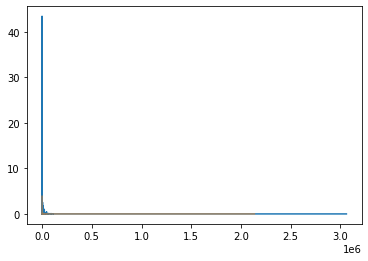

RATE_DOWN_PAYMENT


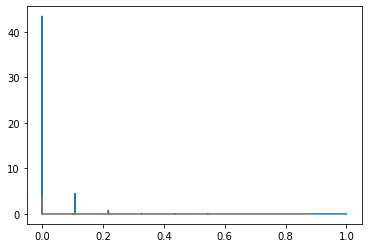

DAYS_DECISION


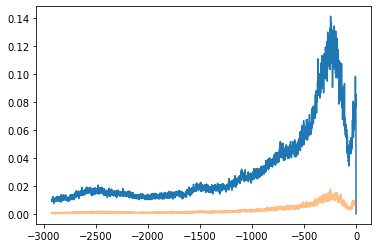

SELLERPLACE_AREA


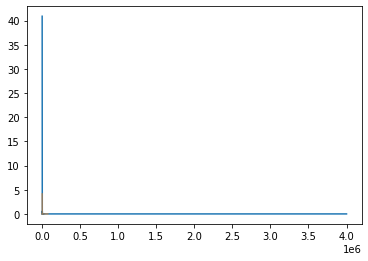

CNT_PAYMENT


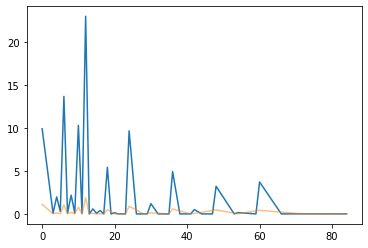

DAYS_FIRST_DRAWING


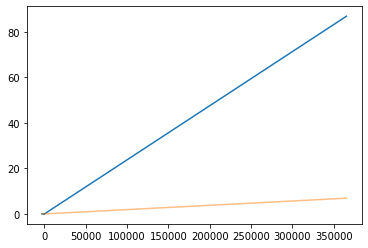

DAYS_FIRST_DUE


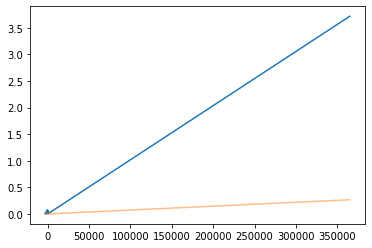

DAYS_LAST_DUE_1ST_VERSION


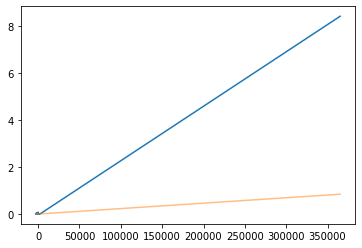

AMT_APPLICATION


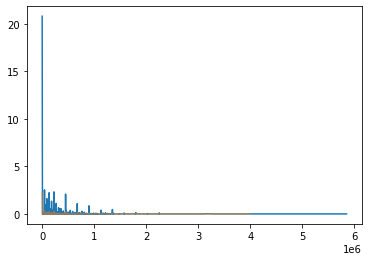

DAYS_TERMINATION


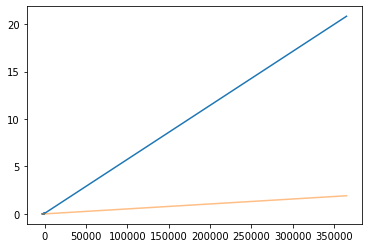

In [19]:
for head in m_heads:
    if head in skip:
        continue
    print(head)
    
#     p = (payback[head].value_counts() - payback[head].value_counts().mean()) / payback[head].value_counts().std()
#     p = p.sort_index()
#     d = (default[head].value_counts() - default[head].value_counts().mean()) / default[head].value_counts().std()
#     d = d.sort_index()
    
    p = payback[head].value_counts() / df[head].value_counts().sum() * 100
    p = p.sort_index()
    d = default[head].value_counts() / df[head].value_counts().sum() * 100
    d = d.sort_index()
    
#     p.hist()
#     d.hist()
    
    plt.plot(p.index, p)
    plt.plot(d.index, d, alpha=0.5)
    
    plt.show()

In [20]:
df[m_heads].head()

,SK_ID_PREV,SK_ID_CURR,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,TARGET,AMT_APPLICATION,DAYS_TERMINATION
0,2030495,271877,0.0,0.000000,-73,35,12.0,365243.0,-42.0,300.0,0,17145.0,-37.0
1,1696966,271877,180000.0,0.101325,-472,55,36.0,NaN,NaN,NaN,0,1800000.0,NaN
2,2154916,271877,0.0,0.000000,-548,196,12.0,365243.0,-512.0,-182.0,0,108400.5,-387.0
3,2802425,108129,NaN,NaN,-164,-1,36.0,365243.0,-134.0,916.0,0,607500.0,365243.0
4,1536272,108129,NaN,NaN,-515,6,36.0,365243.0,-485.0,565.0,0,450000.0,-147.0


In [21]:
for head in m_heads:
    if head in skip:
        continue
    
    print(head, df[head].isna().sum() / len(df[head] * 100))
    

AMT_DOWN_PAYMENT 0.5301969794178543
RATE_DOWN_PAYMENT 0.5301969794178543
DAYS_DECISION 0.0
SELLERPLACE_AREA 0.0
CNT_PAYMENT 0.21731115702683948
DAYS_FIRST_DRAWING 0.396905710613489
DAYS_FIRST_DUE 0.396905710613489
DAYS_LAST_DUE_1ST_VERSION 0.396905710613489
AMT_APPLICATION 0.0
DAYS_TERMINATION 0.396905710613489


In [22]:
fill_zero = ["AMT_DOWN_PAYMENT", "RATE_DOWN_PAYMENT", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_TERMINATION"]
fill_mean = ["CNT_PAYMENT"]

In [23]:
for head in fill_zero:
    df[head] = df[head].fillna(0)

for head in fill_mean:
    df[head] = df[head].fillna(df[head].mean())

<ipython-input-23-ebb0c97b4ade>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[head] = df[head].fillna(0)
<ipython-input-23-ebb0c97b4ade>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[head] = df[head].fillna(df[head].mean())


In [24]:
len(df)

1413701

In [25]:
df[m_heads].head()

,SK_ID_PREV,SK_ID_CURR,AMT_DOWN_PAYMENT,RATE_DOWN_PAYMENT,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,TARGET,AMT_APPLICATION,DAYS_TERMINATION
0,2030495,271877,0.0,0.000000,-73,35,12.0,365243.0,-42.0,300.0,0,17145.0,-37.0
1,1696966,271877,180000.0,0.101325,-472,55,36.0,0.0,0.0,0.0,0,1800000.0,0.0
2,2154916,271877,0.0,0.000000,-548,196,12.0,365243.0,-512.0,-182.0,0,108400.5,-387.0
3,2802425,108129,0.0,0.000000,-164,-1,36.0,365243.0,-134.0,916.0,0,607500.0,365243.0
4,1536272,108129,0.0,0.000000,-515,6,36.0,365243.0,-485.0,565.0,0,450000.0,-147.0


In [26]:
pa = df.copy()

In [27]:
quants = [0,0.25,0.5,0.75,1]

In [28]:
for index, head in enumerate(m_heads):
    if head in skip:
        continue
        
    df = pa[["SK_ID_CURR", head]]
    df = df.groupby(by = ["SK_ID_CURR"]).quantile(quants)
    df = df.unstack(level=-1)
    
    try:
        mets = mets.join(df, on = "SK_ID_CURR")
    except (ValueError, NameError):
        mets = df

df = mets

In [32]:
df.columns = [head[0] + "_" + str(head[1]) for head in df.columns]

In [33]:
df.head()

,AMT_DOWN_PAYMENT_0.0,AMT_DOWN_PAYMENT_0.25,AMT_DOWN_PAYMENT_0.5,AMT_DOWN_PAYMENT_0.75,AMT_DOWN_PAYMENT_1.0,RATE_DOWN_PAYMENT_0.0,RATE_DOWN_PAYMENT_0.25,RATE_DOWN_PAYMENT_0.5,RATE_DOWN_PAYMENT_0.75,RATE_DOWN_PAYMENT_1.0,DAYS_DECISION_0.0,DAYS_DECISION_0.25,DAYS_DECISION_0.5,DAYS_DECISION_0.75,DAYS_DECISION_1.0,SELLERPLACE_AREA_0.0,SELLERPLACE_AREA_0.25,SELLERPLACE_AREA_0.5,SELLERPLACE_AREA_0.75,SELLERPLACE_AREA_1.0,CNT_PAYMENT_0.0,CNT_PAYMENT_0.25,CNT_PAYMENT_0.5,CNT_PAYMENT_0.75,CNT_PAYMENT_1.0,DAYS_FIRST_DRAWING_0.0,DAYS_FIRST_DRAWING_0.25,DAYS_FIRST_DRAWING_0.5,DAYS_FIRST_DRAWING_0.75,DAYS_FIRST_DRAWING_1.0,DAYS_FIRST_DUE_0.0,DAYS_FIRST_DUE_0.25,DAYS_FIRST_DUE_0.5,DAYS_FIRST_DUE_0.75,DAYS_FIRST_DUE_1.0,DAYS_LAST_DUE_1ST_VERSION_0.0,DAYS_LAST_DUE_1ST_VERSION_0.25,DAYS_LAST_DUE_1ST_VERSION_0.5,DAYS_LAST_DUE_1ST_VERSION_0.75,DAYS_LAST_DUE_1ST_VERSION_1.0,AMT_APPLICATION_0.0,AMT_APPLICATION_0.25,AMT_APPLICATION_0.5,AMT_APPLICATION_0.75,AMT_APPLICATION_1.0,DAYS_TERMINATION_0.0,DAYS_TERMINATION_0.25,DAYS_TERMINATION_0.5,DAYS_TERMINATION_0.75,DAYS_TERMINATION_1.0
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-606.0,-606.0,-606.0,-606.0,-606.0,500.0,500.00,500.0,500.00,500.0,24.0,24.0,24.000000,24.0,24.0,365243.0,365243.0,365243.0,365243.0,365243.0,-565.0,-565.0,-565.0,-565.0,-565.0,125.0,125.0,125.0,125.0,125.0,179055.0,179055.00,179055.0,179055.0,179055.0,-17.0,-17.0,-17.0,-17.00,-17.0
100003,0.0,0.0,0.0,3442.50,6885.0,0.000000,0.000000,0.000000,0.050030,0.100061,-2341.0,-1584.5,-828.0,-787.0,-746.0,-1.0,99.50,200.0,800.00,1400.0,6.0,9.0,12.000000,12.0,12.0,365243.0,365243.0,365243.0,365243.0,365243.0,-2310.0,-1553.5,-797.0,-756.5,-716.0,-1980.0,-1313.5,-647.0,-516.5,-386.0,68809.5,203154.75,337500.0,618750.0,900000.0,-1976.0,-1307.5,-639.0,-583.00,-527.0
100004,4860.0,4860.0,4860.0,4860.00,4860.0,0.212008,0.212008,0.212008,0.212008,0.212008,-815.0,-815.0,-815.0,-815.0,-815.0,30.0,30.00,30.0,30.00,30.0,4.0,4.0,4.000000,4.0,4.0,365243.0,365243.0,365243.0,365243.0,365243.0,-784.0,-784.0,-784.0,-784.0,-784.0,-694.0,-694.0,-694.0,-694.0,-694.0,24282.0,24282.00,24282.0,24282.0,24282.0,-714.0,-714.0,-714.0,-714.00,-714.0
100006,0.0,0.0,0.0,0.00,66987.0,0.000000,0.000000,0.000000,0.000000,0.217830,-617.0,-311.0,-181.0,-181.0,-181.0,-1.0,-1.00,-1.0,-1.00,8025.0,0.0,12.0,16.051936,18.0,48.0,0.0,0.0,0.0,365243.0,365243.0,-545.0,-151.0,0.0,0.0,365243.0,-215.0,0.0,0.0,49.0,365243.0,0.0,0.00,270000.0,454500.0,688500.0,-416.0,0.0,0.0,0.00,365243.0
100007,0.0,0.0,0.0,2328.75,3676.5,0.000000,0.000000,0.000000,0.075107,0.218890,-2357.0,-1602.5,-986.5,-865.5,-374.0,-1.0,0.25,28.5,913.25,1200.0,10.0,12.0,15.000000,22.5,48.0,0.0,365243.0,365243.0,365243.0,365243.0,-2326.0,-1571.0,-955.0,-466.5,0.0,-2056.0,-1241.0,-535.0,-81.0,346.0,17176.5,68253.75,191250.0,219375.0,247500.0,-2041.0,-1232.5,-543.0,-86.75,365243.0


In [37]:
df.to_csv(DATASET_DIR / "Datenaufbereitung" / "pa_mets.csv")

In [38]:
len(df)

291057